In [1]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install torch
!pip install matplotlib
!pip install scipy
!pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from scipy.signal import stft

### GPU SETTING

In [3]:
if torch.cuda.is_available():
    # 사용 가능한 GPU의 개수
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    # Device 세팅
    device = torch.device("cuda")
    print("GPU is available and set as the current device.")

    # 현재 device로 설정된 GPU 확인
    current_device = torch.cuda.current_device()
    print(f"Current GPU Device: index[{current_device}]")
    
    # 현재 device로 설정된 GPU의 이름 출력
    print(f"Device name: {torch.cuda.get_device_name(current_device)}")
    
    
else:
    print("GPU is not available, using CPU instead.")
    device = torch.device("cpu")

Number of GPUs available: 1
GPU is available and set as the current device.
Current GPU Device: index[0]
Device name: NVIDIA GeForce GTX 1050 Ti


### DATA SETTING

In [2]:
sensor1 = pd.read_csv("raw_data/g1_sensor1.csv",names=["time","normal","type1","type2","type3"])
sensor2 = pd.read_csv("raw_data/g1_sensor2.csv",names=["time","normal","type1","type2","type3"])
sensor3 = pd.read_csv("raw_data/g1_sensor3.csv",names=["time","normal","type1","type2","type3"])
sensor4 = pd.read_csv("raw_data/g1_sensor4.csv",names=["time","normal","type1","type2","type3"])

In [3]:
print("sensor 1의 데이터 크기",sensor1.shape) # 190218개의 행, 5의 열
print("sensor 1의 데이터 크기",sensor2.shape)
print("sensor 1의 데이터 크기",sensor3.shape)
print("sensor 1의 데이터 크기",sensor4.shape)

sensor 1의 데이터 크기 (190218, 5)
sensor 1의 데이터 크기 (184211, 5)
sensor 1의 데이터 크기 (196079, 5)
sensor 1의 데이터 크기 (183969, 5)


In [4]:
from scipy import interpolate
x_new = np.arange(0,140,0.001) # 0,0.001,0.002,,,,,,139.999
y_new1 = []
y_new2 = []
y_new3 = []
y_new4 = []

# 모든 센서의 각 타입 데이터 별로 선형 보간을 수행한 결과를 추출
# normal = 정상 데이터, type1 = 질량 불균형 고장상태, type2 = 지지불량 고장상태, type3 = 질량 불균형과 지지불량 고장 상태
for item in ["normal","type1","type2","type3"]:
    f_linear1 = interpolate.interp1d(sensor1["time"],sensor1[item],kind="linear") 
    y_new1.append(f_linear1(x_new)) 

    f_linear2 = interpolate.interp1d(sensor2["time"],sensor2[item],kind="linear")
    y_new2.append(f_linear2(x_new))
    f_linear3 = interpolate.interp1d(sensor3["time"],sensor3[item],kind="linear")
    y_new3.append(f_linear3(x_new))
    f_linear4 = interpolate.interp1d(sensor4["time"],sensor4[item],kind="linear")
    y_new4.append(f_linear4(x_new))


In [7]:
sensor1

,time,normal,type1,type2,type3
0,0.000000,-0.853307,-3.464579,0.555219,3.919664
1,0.000736,-0.740463,-2.448986,-0.234687,4.145351
2,0.001472,-0.138630,-1.922383,-0.009000,2.941685
3,0.002208,0.049443,-0.906790,-0.272301,2.603155
4,0.002944,-0.289088,-0.568259,-0.986978,1.361874
...,...,...,...,...,...
190213,139.996768,-1.156354,-2.696750,0.844491,-2.109427
190214,139.997504,-0.930666,-1.380241,0.919720,-2.222270
190215,139.998240,-0.554521,-2.132532,0.731647,-2.109427
190216,139.998976,-1.419655,-2.433448,1.183022,-3.087405


In [6]:
# 시간축을 기준으로, 모든 센서에서 추출된 데이터를 이어붙인다.
normal_ = pd.concat([sensor1["normal"],sensor2["normal"],sensor3["normal"],sensor4["normal"]],axis=1) # 각 센서에서 추출된 normal 데이터 
type1_ = pd.concat([sensor1["type1"],sensor2["type1"],sensor3["type1"],sensor4["type1"]],axis=1) # Type 1 이상치 데이터
type2_ = pd.concat([sensor1["type2"],sensor2["type2"],sensor3["type2"],sensor4["type2"]],axis=1) # Type 2 이상치 데이터
type3_ = pd.concat([sensor1["type3"],sensor2["type3"],sensor3["type3"],sensor4["type3"]],axis=1) # Type 3 이상치 데이터

# 어디 센서에서 나온 결과인지, 열의 이름 달기
normal_.columns = ["s1","s2","s3","s4"]
type1_.columns = ["s1","s2","s3","s4"]
type2_.columns = ["s1","s2","s3","s4"]
type3_.columns = ["s1","s2","s3","s4"]

In [9]:
normal_

,s1,s2,s3,s4
0,-0.853307,0.048823,-0.437626,-1.116226
1,-0.740463,-0.029477,-0.437626,-0.379672
2,-0.138630,-0.029477,0.280889,-1.271290
3,0.049443,0.009673,0.280889,-0.612268
4,-0.289088,0.009673,-0.257997,-0.689800
...,...,...,...,...
196074,NaN,NaN,-0.257427,NaN
196075,NaN,NaN,0.146738,NaN
196076,NaN,NaN,0.371273,NaN
196077,NaN,NaN,0.416181,NaN


### DATA ANALYSIS

- 기본적인 분포
    * 주파수가 현재 normal, type1, type2, type3가 달라서, 정규 분포가 다름

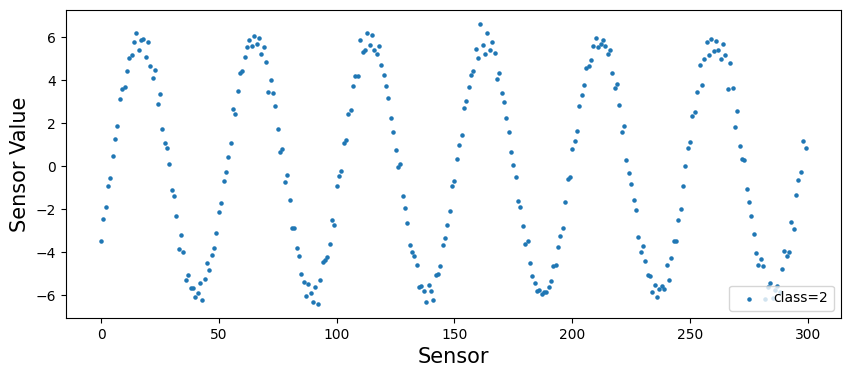

In [8]:
plt.figure(figsize=(10,4))
# plt.scatter(range(0,300),normal_["s1"][:300],label="class="+str(1),marker='o',s =5) # x축: (0,300), y축: normal_["s1"][:300]
plt.scatter(range(0,300),type1_["s1"][:300],label="class="+str(2),marker='o',s =5)
# plt.scatter(range(0,300),type2_["s1"][:300],label="class="+str(3),marker='o',s =5)
# plt.scatter(range(0,300),type3_["s1"][:300],label="class="+str(4),marker='o',s =5)

plt.legend(loc="lower right")
plt.xlabel("Sensor",fontsize=15)
plt.ylabel("Sensor Value",fontsize=15)
plt.show()
plt.close()

# STFT

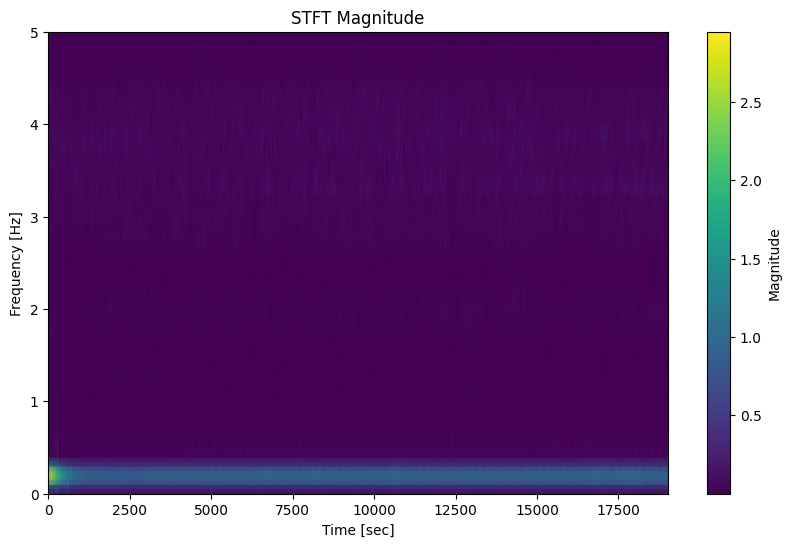

In [18]:
from scipy import signal

# STFT 변환
f, t, Zxx = signal.stft(sensor1["type1"], fs=10, nperseg=100)

# STFT 결과 시각화
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude')
plt.show()

# CWT

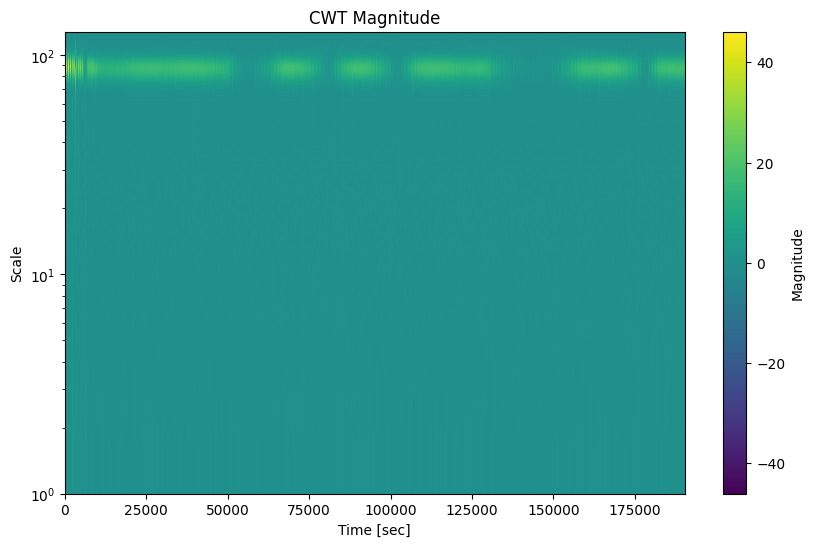

In [13]:
import pywt
# CWT 변환
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(sensor1["type1"], scales, "morl")

# CWT 결과 시각화
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(coefficients),
    extent=[0, len(sensor1["type1"]), 1, 128],
    aspect="auto",
    vmax=np.abs(coefficients).max(),
    vmin=-np.abs(coefficients).max(),
)
plt.yscale('log')
plt.colorbar(label="Magnitude")
plt.title("CWT Magnitude")
plt.ylabel("Scale")
plt.xlabel("Time [sec]")
plt.show()

- 상관관계 확인
    * 왠지는 모르겠지만, 안됨

In [ ]:
names = ["s1","s2","s3","s4"]
cm = np.corrcoef(normal_.values.T)
sns.set(font_scale=0.8)
sns.heatmap(cm,annot=True,square=True,fmt=".2f",annot_kws={"size":10},yticklabels=names,xticklabels=names,cmap=plt.cm.Blues)


- FFT
    * 데이터 최대 주파수 확인용

In [ ]:
def find_max_frequency(signal, fs=0.001):
    """
    신호의 최대 주파수 성분을 찾는 함수입니다.
    
    Parameters:
    signal: 시간 도메인 데이터 (1차원 numpy 배열)
    fs: 샘플링 주파수 (Hz) -> step(0.001)
    
    Returns:
    max_freq: 최대 주파수 성분 (Hz)
    magnitude_max_freq: 최대 주파수 성분의 magnitude
    """
    # FFT 계산
    n = len(signal)
    freqs = np.fft.fftfreq(n, d=1/fs)
    fft_values = np.fft.fft(signal)
    
    # Magnitude 계산
    magnitudes = np.abs(fft_values)
    
    # Nyquist 주파수까지만 고려
    half_n = n // 2
    freqs = freqs[:half_n]
    magnitudes = magnitudes[:half_n]
    
    # 최대 주파수 성분 찾기
    max_idx = np.argmax(magnitudes)
    max_freq = freqs[max_idx]
    magnitude_max_freq = magnitudes[max_idx]
    
    return max_freq, magnitude_max_freq
find_max_frequency(sensor1["normal"])

- STFT
    * 각 데이터가 어떤 주파수 분포를 띄고 있는지 확인할 수 있다.

In [ ]:
def check_stft(data,result_label,fs=500,nperseg=64):
    signal = data[result_label]

    noverlap = nperseg // 2
    nfft = nperseg

    # STFT
    f,t,Zxx = stft(signal,fs=fs, nperseg = nperseg, noverlap=noverlap, nfft = nfft)

    # STFT 결과를 이미지로 저장합니다.
    plt.figure()
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=np.abs(Zxx).max(), shading='auto', cmap='jet')

    # x축과 y축 라벨 추가
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    
    # 컬러바 추가
    plt.colorbar(label='Magnitude')

    # 제목 추가
    plt.title(f"STFT Magnitude of {result_label}")

    plt.show()
    plt.close()

# "normal","type1","type2","type3"
print(sensor1["normal"])
check_stft(sensor1,"normal")

### DATA PREPROCESSING

In [ ]:
M =15 # 이동평균 필터 사이즈
# 노이즈 제거
# 1. normal의 이동 평균 필터 적용 + 열벡터로 데이터 재구성
normal_s1 = np.convolve(normal_['s1'], np.ones(M), 'valid') / M; normal_s1 = normal_s1.reshape(len(normal_s1),1) 
normal_s2 = np.convolve(normal_['s2'], np.ones(M), 'valid') / M; normal_s2 = normal_s2.reshape(len(normal_s2),1)
normal_s3 = np.convolve(normal_['s3'], np.ones(M), 'valid') / M; normal_s3 = normal_s3.reshape(len(normal_s3),1)
normal_s4 = np.convolve(normal_['s4'], np.ones(M), 'valid') / M; normal_s4 = normal_s4.reshape(len(normal_s4),1)

# 2. type1의 이동 평균 필터 적용 + 열벡터로 데이터 재구성
type1_s1 = np.convolve(type1_['s1'], np.ones(M), 'valid') / M; type1_s1 = type1_s1.reshape(len(type1_s1),1)
type1_s2 = np.convolve(type1_['s2'], np.ones(M), 'valid') / M; type1_s2 = type1_s2.reshape(len(type1_s2),1)
type1_s3 = np.convolve(type1_['s3'], np.ones(M), 'valid') / M; type1_s3 = type1_s3.reshape(len(type1_s3),1)
type1_s4 = np.convolve(type1_['s4'], np.ones(M), 'valid') / M; type1_s4 = type1_s4.reshape(len(type1_s4),1)

# 3. type2의 이동 평균 필터 적용 + 열벡터로 데이터 재구성
type2_s1 = np.convolve(type2_['s1'], np.ones(M), 'valid') / M; type2_s1 = type2_s1.reshape(len(type2_s1),1)
type2_s2 = np.convolve(type2_['s2'], np.ones(M), 'valid') / M; type2_s2 = type2_s2.reshape(len(type2_s2),1)
type2_s3 = np.convolve(type2_['s3'], np.ones(M), 'valid') / M; type2_s3 = type2_s3.reshape(len(type2_s3),1)
type2_s4 = np.convolve(type2_['s4'], np.ones(M), 'valid') / M; type2_s4 = type2_s4.reshape(len(type2_s4),1)

# 4. type3의 이동 평균 필터 적용 + 열벡터로 데이터 재구성
type3_s1 = np.convolve(type3_['s1'], np.ones(M), 'valid') / M; type3_s1 = type3_s1.reshape(len(type3_s1),1)
type3_s2 = np.convolve(type3_['s2'], np.ones(M), 'valid') / M; type3_s2 = type3_s2.reshape(len(type3_s2),1)
type3_s3 = np.convolve(type3_['s3'], np.ones(M), 'valid') / M; type3_s3 = type3_s3.reshape(len(type3_s3),1)
type3_s4 = np.convolve(type3_['s4'], np.ones(M), 'valid') / M; type3_s4 = type3_s4.reshape(len(type3_s4),1)

# 5. 이동평균 구한거 합치기
normal_temp = np.concatenate((normal_s1,normal_s2,normal_s3,normal_s4), axis =1)
type1_temp = np.concatenate((type1_s1,type1_s2,type1_s3,type1_s4), axis =1)
type2_temp = np.concatenate((type2_s1,type2_s2,type2_s3,type2_s4), axis =1)
type3_temp = np.concatenate((type3_s1,type3_s2,type3_s3,type3_s4), axis =1)



In [ ]:
# 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(normal_) # normal_데이터셋의 데이터 분포가 어떻게 정규화되어 있는지 학습

# normal_ 데이터셋 분포에 맞게 다른 모든 데이터 셋의 분포를 전환
normal = scaler.transform(normal_temp)
type1 = scaler.transform(type1_temp)
type2 = scaler.transform(type2_temp)
type3 = scaler.transform(type3_temp)

### DATA SPLIT ->(Train, Valid, Test)

In [ ]:
print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

In [ ]:
# 끝에 NAN 쓰레기값, 초반에 불안정함때문에 중간 100,000개만 데이터로 사용
normal = normal[30000:130000][:]
type1 = type1[30000:130000][:]
type2 = type2[30000:130000][:]
type3 = type3[30000:130000][:]
print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

In [ ]:
# 데이터 분배, train = 60,000개, valid = 20,000개, test = 20,000개 
normal_train = normal[:][:60000]; normal_valid = normal[:][60000:80000]; normal_test =normal[:][80000:]
type1_train = type1[:][:60000]; type1_valid = type1[:][60000:80000]; type1_test =type1[:][80000:]
type2_train = type2[:][:60000]; type2_valid = type2[:][60000:80000]; type2_test =type2[:][80000:]
type3_train = type3[:][:60000]; type3_valid = type3[:][60000:80000]; type3_test =type3[:][80000:]

# 데이터 합치기
train = np.concatenate((normal_train,type1_train,type2_train,type3_train))
valid = np.concatenate((normal_valid,type1_valid,type2_valid,type3_valid))
test = np.concatenate((normal_test,type1_test,type2_test,type3_test))
print("train data의 형태:", train.shape) # normal_train -> type1_train -> type2_train -> type3_train: 같은 분포
print("valid data의 형태:", valid.shape)
print(" test data의 형태:", test.shape)

In [ ]:
# 모델이 예측한 결과값을 담을 데이터 구조 생성
train_label = np.concatenate((np.full((60000,1),0), np.full((60000,1),1),
np.full((60000,1),2), np.full((60000,1),3)))
valid_label = np.concatenate((np.full((20000,1),0), np.full((20000,1),1),
np.full((20000,1),2), np.full((20000,1),3)))
test_label = np.concatenate((np.full((20000,1),0), np.full((20000,1),1),
np.full((20000,1),2), np.full((20000,1),3)))

In [ ]:
# train data, valid data, test data 전부 index 셔플
idx = np.arange(train.shape[0]); np.random.shuffle(idx);
train = train[:][idx]; train_label = train_label[:][idx]
idx_v = np.arange(valid.shape[0]); np.random.shuffle(idx_v);
valid = valid[:][idx_v]; valid_label = valid_label[:][idx_v]
idx_t = np.arange(test.shape[0]); np.random.shuffle(idx_t);
test = test[:][idx_t]; test_label = test_label[:][idx_t]

In [ ]:
# 토치 텐서로 변환, 그냥 좀 절삭
x_train = torch.from_numpy(train).float()
y_train = torch.from_numpy(train_label).float().T[0]
x_valid = torch.from_numpy(valid).float()
y_valid = torch.from_numpy(valid_label).float().T[0]
x_test = torch.from_numpy(test).float()
y_test = torch.from_numpy(test_label).float().T[0]
print("변경 전")
train

In [ ]:
print("변경 후")
x_train

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# 데이터셋 생성 및 배치사이즈로 미리 나누며 iterator 생성
BATCH_SIZE = 5000
train = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train, batch_size =BATCH_SIZE, shuffle=True)
valid = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid, batch_size =len(x_valid), shuffle=False)
test = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test, batch_size =len(x_valid), shuffle=False)

### SET AI MODEL

In [ ]:
class KAMP_DNN(nn.Module):
    def __init__(self):
        super(KAMP_DNN, self).__init__()
        self.layer1 = nn.Linear(in_features =4, out_features =100)
        self.layer2 = nn.Linear(in_features =100, out_features =100)
        self.layer3 = nn.Linear(in_features =100, out_features =100)
        self.layer4 = nn.Linear(in_features =100, out_features =4)

        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    def forward(self, input):
        out =self.layer1(input)
        out =self.relu(out)
        out =self.dropout(out)

        out =self.layer2(out)
        out =self.relu(out)
        out =self.dropout(out)

        out =self.layer3(out)
        out =self.relu(out)
        out =self.dropout(out)

        out =self.layer4(out)
        return out

model_check = KAMP_DNN()
print(model_check)

In [ ]:
class KAMP_CNN(nn.Module):
    def __init__(self):
        super(KAMP_CNN, self).__init__()
        self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=100, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1),
        nn.Dropout(p=0.2))

        self.conv2 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1),
        nn.Dropout(p=0.2))

        self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1),
        nn.Dropout(p=0.2))

        self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=4, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(4),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1))

        self.final_pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(4, 4)
        
    def forward(self, input):
        input = input.unsqueeze(1)
        out =self.conv1(input)
        # out = self.conv2(out)
        # out = self.conv3(out)
        out =self.conv4(out)
        out =self.final_pool(out)
        out =self.linear(out.squeeze(-1))
        return out
model_check = KAMP_CNN()
print(model_check)

In [ ]:
print('--------------------------------------------------------------------')
input = torch.tensor([[[0.0, 6.0, 9.0, 1.0]]])
print('"input is same below."')
print(input)
print('--------------------------------------------------------------------')
model = nn.Conv1d(1, 4, 2, bias =False)
model.weight.data = torch.zeros(model.weight.data.size())
model.weight.data[:, :, :2] =1
print('"kernal is same below."')
print(model.weight.data)
print('--------------------------------------------------------------------')
output = model(input)
print('"output is same below (without bias)."')
print(output)
print('--------------------------------------------------------------------')
model1 = nn.Conv1d(1, 4, 2)
model1.weight.data = torch.zeros(model1.weight.data.size())
model1.weight.data[:, :, :2] =1
output = model1(input)
print('"output is same below (with bias)."')
print(output)
print('--------------------------------------------------------------------')

In [ ]:
import torch
import torch.nn as nn
class KAMP_RNN(nn.Module):
    def __init__(self):
        super(KAMP_RNN, self).__init__()
        self.lstm = nn.LSTM(input_size =4, hidden_size =100, num_layers =2,
        batch_first=True, dropout =0.2)
        self.fc = nn.Linear(in_features =100, out_features =4)
    def forward(self, input):
        input = input.unsqueeze(1)
        out, _ =self.lstm(input)
        out = out.view(-1,100)
        output =self.fc(out)
        return output

model_check = KAMP_RNN()
print(model_check)

### TRAINING

In [ ]:
# GPU: device
def train_model(model, criterion, optimizer, num_epoch, train_dataloader, PATH):
 # Model을 GPU로 이동
 model.to(device)

 
 loss_values = []
 loss_values_v = [] 
 accuracy_past =0
 for epoch in range(1, num_epochs +1):
    #---------------------- 모델 학습 ---------------------#
    model.train()
    batch_number =0
    running_loss =0.0
    for batch_idx, samples in enumerate(train_dataloader):
        # 데이터 GPU로 옮기기
        x_train, y_train = samples[0].to(device), samples[1].to(device) 

        # 변수 초기화
        optimizer.zero_grad()
        y_hat = model.forward(x_train)
        loss = criterion(y_hat,y_train.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_number +=1

    loss_values.append(running_loss / batch_number)
 #---------------------- 모델 검증 ---------------------#
    model.eval()
    accuracy =0.0
    total =0.0
    for batch_idx, data in enumerate(valid_dataloader):
        x_valid, y_valid = data[0].to(device), data[1].to(device)

        v_hat = model.forward(x_valid)
        v_loss = criterion(v_hat,y_valid.long())
        _, predicted = torch.max(v_hat.data, 1)
        total += y_valid.size(0)
        accuracy += (predicted == y_valid).sum().item()
    loss_values_v.append(loss.item())
    accuracy = (accuracy / total)
 #----------------Check for early stopping---------------#
    if epoch % 1 ==0:
        print('[Epoch {}/{}] [Train_Loss: {:.6f} /Valid_Loss: {:.6f}]'.format(epoch, num_epochs, loss.item(),v_loss.item()))
        print('[Epoch {}/{}] [Accuracy : {:.6f}]'.format(epoch, num_epochs, accuracy))
    
    # checkpoint + early stopping
    if accuracy_past < accuracy:
        accuracy_past = accuracy
        torch.save(model.state_dict(), PATH + f'model_epoch_{epoch}_acc_{accuracy:.4f}.pt')
        print(f"Checkpoint saved at epoch {epoch} with validation accuracy {accuracy:.4f}.")

# return loss..
 return loss_values, loss_values_v

- For CNN

In [ ]:
CNN_model = KAMP_CNN()
num_epochs =1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters())
PATH ='save/CNN/'
CNN_loss_values, CNN_loss_values_v = train_model(CNN_model, criterion, optimizer,
num_epochs, train_dataloader, PATH)

- For RNN

In [ ]:
RNN_model = KAMP_RNN()
num_epochs =1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RNN_model.parameters())
PATH ='save/RNN/'
RNN_loss_values, RNN_loss_values_v = train_model(RNN_model, criterion, optimizer,
num_epochs, train_dataloader, PATH)

### TEST

In [ ]:
def test_model(model, PATH):
    model = torch.load(PATH +'model.pt')
    #---------------------- 모델 시험 ---------------------#
    model.eval()
    total =0.0
    accuracy =0.0
    for batch_idx, data in enumerate(test_dataloader):
        x_test, y_test = data[0].to(device),data[1].to(device)

        t_hat = model(x_test)
        _, predicted = torch.max(t_hat.data, 1)
        total += y_test.size(0)
        accuracy += (predicted == y_test).sum().item()
    accuracy = (accuracy / total)
    #------------------------------------------------------#
    print(accuracy)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def draw_confusion_matrix(model, xt, yt, PATH):
    y_pred = []; y_true = []
    # 1. 모델 예측 결과 뽑기
    model.eval()
    y_hat = model(xt) # y_hat은 모델로 예측한 결과
    output = (torch.max(torch.exp(y_hat), 1)[1]).data.cpu().numpy() # 결과값만 추출 
    y_pred.extend(output)

    # 2. 실제 정답값 뽑기
    labels = y_test.data.cpu().numpy()
    y_true.extend(labels)
    # 분류 항목
    classes = ('Normal', 'Type1', 'Type2', 'Type3')

    # Confussion Matrix 생성
    plt.figure(figsize = (7,5))
    dlen = float(len(x_test)) # test data 크기 : 여기서는 80000
    cm = confusion_matrix(y_true, y_pred) 

    df_cm = pd.DataFrame(cm/dlen, index = [i for i in classes],columns = [i for i in classes])
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix", size=24, fontweight='bold')
    plt.xlabel("Predicted Label", size=16); plt.ylabel("Actual Label", size=16)
    plt.rc('xtick', labelsize=12); plt.rc('ytick', labelsize=12); plt.yticks(rotation=0)
    plt.savefig(PATH +'cm_output.png')

In [ ]:
def plot_loss_graph(loss_values, loss_values_v):
    plt.figure()
    plt.plot(loss_values)
    plt.plot(loss_values_v)
    plt.title("Training & Validation Loss")
    plt.ylabel("loss", fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "validation"])
    plt.tight_layout()
    # 결과 저장
    plt.savefig(PATH +'lossplot_output.png')

- Check Accuracy

In [ ]:
test_model(CNN_model,'save/CNN/')
# test_model(RNN_model,'save/RNN/')

- Check Confusion Matrix

In [ ]:
draw_confusion_matrix(CNN_model, x_test, y_test, 'save/CNN/')
draw_confusion_matrix(RNN_model, x_test, y_test, 'save/RNN/')

- Check Loss function

In [ ]:
plot_loss_graph(CNN_loss_values, CNN_loss_values_v)
plot_loss_graph(RNN_loss_values, RNN_loss_values_v)